# Look at Enron data set

## Loading data
I load the original data. The data is provided as a dcitionary. The keys are the names of the Enron employees.

In [15]:
import pickle
import numpy as np
data_dict = pickle.load(open("final_project_dataset.pkl", "r"))
names = data_dict.keys()
features = []
labels = [item["poi"] for item in data_dict.values()]
for item in data_dict.values():
    new_item = {}
    for key, value in item.items():
        if key=="poi": continue
        if value == "NaN":
            new_item[key] = np.nan
        else:
            new_item[key] = value
    features.append(new_item)
names

['METTS MARK',
 'BAXTER JOHN C',
 'ELLIOTT STEVEN',
 'CORDES WILLIAM R',
 'HANNON KEVIN P',
 'MORDAUNT KRISTINA M',
 'MEYER ROCKFORD G',
 'MCMAHON JEFFREY',
 'HORTON STANLEY C',
 'PIPER GREGORY F',
 'HUMPHREY GENE E',
 'UMANOFF ADAM S',
 'BLACHMAN JEREMY M',
 'SUNDE MARTIN',
 'GIBBS DANA R',
 'LOWRY CHARLES P',
 'COLWELL WESLEY',
 'MULLER MARK S',
 'JACKSON CHARLENE R',
 'WESTFAHL RICHARD K',
 'WALTERS GARETH W',
 'WALLS JR ROBERT H',
 'KITCHEN LOUISE',
 'CHAN RONNIE',
 'BELFER ROBERT',
 'SHANKMAN JEFFREY A',
 'WODRASKA JOHN',
 'BERGSIEKER RICHARD P',
 'URQUHART JOHN A',
 'BIBI PHILIPPE A',
 'RIEKER PAULA H',
 'WHALEY DAVID A',
 'BECK SALLY W',
 'HAUG DAVID L',
 'ECHOLS JOHN B',
 'MENDELSOHN JOHN',
 'HICKERSON GARY J',
 'CLINE KENNETH W',
 'LEWIS RICHARD',
 'HAYES ROBERT E',
 'MCCARTY DANNY J',
 'KOPPER MICHAEL J',
 'LEFF DANIEL P',
 'LAVORATO JOHN J',
 'BERBERIAN DAVID',
 'DETMERING TIMOTHY J',
 'WAKEHAM JOHN',
 'POWERS WILLIAM',
 'GOLD JOSEPH',
 'BANNANTINE JAMES M',
 'DUNCAN JOHN H'

[{'bonus': 600000,
  'deferral_payments': nan,
  'deferred_income': nan,
  'director_fees': nan,
  'email_address': 'mark.metts@enron.com',
  'exercised_stock_options': nan,
  'expenses': 94299,
  'from_messages': 29,
  'from_poi_to_this_person': 38,
  'from_this_person_to_poi': 1,
  'loan_advances': nan,
  'long_term_incentive': nan,
  'other': 1740,
  'restricted_stock': 585062,
  'restricted_stock_deferred': nan,
  'salary': 365788,
  'shared_receipt_with_poi': 702,
  'to_messages': 807,
  'total_payments': 1061827,
  'total_stock_value': 585062},
 {'bonus': 1200000,
  'deferral_payments': 1295738,
  'deferred_income': -1386055,
  'director_fees': nan,
  'email_address': nan,
  'exercised_stock_options': 6680544,
  'expenses': 11200,
  'from_messages': nan,
  'from_poi_to_this_person': nan,
  'from_this_person_to_poi': nan,
  'loan_advances': nan,
  'long_term_incentive': 1586055,
  'other': 2660303,
  'restricted_stock': 3942714,
  'restricted_stock_deferred': nan,
  'salary': 2671

## Basic data features
Number of samples:

In [10]:
len(names)

146

Number of persons of interest (POIs):

In [11]:
sum(labels)

18

In [64]:
import pandas as pd
data = pd.DataFrame(features, index=names)
data["poi"]=labels
def get_count_miss_vals(data):
    colnames = []
    n_miss = []
    for col in data.columns:
        if data[col].dtype == np.float_:
            colnames.append(col)
            n_miss.append(sum(np.isnan(data[col])))
    df=pd.DataFrame(n_miss, index=colnames, columns=["n_missing"]).sort_values(by="n_missing", ascending=False)
    df["non_miss"]=len(data)-df["n_missing"]
    return df

get_count_miss_vals(data)

,n_missing,non_miss
loan_advances,142,4
director_fees,129,17
restricted_stock_deferred,128,18
deferral_payments,107,39
deferred_income,97,49
long_term_incentive,80,66
bonus,64,82
from_poi_to_this_person,60,86
from_this_person_to_poi,60,86
from_messages,60,86


In [57]:
def get_col_types(data):
    colnames = []
    coltypes = []
    for col in data.columns:
        colnames.append(col)
        coltypes.append(data[col].dtype)
    return pd.DataFrame(coltypes, index=colnames, columns=["coltypes"]).sort_values(by="coltypes", ascending=False)
get_col_types(data)

,coltypes
email_address,object
bonus,float64
long_term_incentive,float64
total_stock_value,float64
total_payments,float64
to_messages,float64
shared_receipt_with_poi,float64
salary,float64
restricted_stock_deferred,float64
restricted_stock,float64


In [66]:
def get_n_pois_for_miss_vals(data):
    colnames = []
    n_pois = []
    for col in data.columns:
        if data[col].dtype == np.float_:
            colnames.append(col)
            n_pois.append(sum(data["poi"][np.isnan(data[col])]))
    return pd.DataFrame(n_pois, index=colnames, columns=["n_pois"]).sort_values(by="n_pois", ascending=False)
get_n_pois_for_miss_vals(data)

,n_pois
restricted_stock_deferred,18
director_fees,18
loan_advances,17
deferral_payments,13
deferred_income,7
exercised_stock_options,6
long_term_incentive,6
to_messages,4
from_messages,4
from_poi_to_this_person,4


In [89]:
data[np.isnan(data["director_fees"])==False]["poi"]

CHAN RONNIE                False
BELFER ROBERT              False
URQUHART JOHN A            False
MENDELSOHN JOHN            False
WAKEHAM JOHN               False
POWERS WILLIAM             False
DUNCAN JOHN H              False
LEMAISTRE CHARLES          False
MEYER JEROME J             False
PEREIRA PAULO V. FERRAZ    False
BLAKE JR. NORMAN P         False
TOTAL                      False
JAEDICKE ROBERT            False
WINOKUR JR. HERBERT S      False
BHATNAGAR SANJAY           False
SAVAGE FRANK               False
GRAMM WENDY L              False
Name: poi, dtype: bool

To get a first look a t the data, I construct a 2 dimensional representation of the data using a technique called [t-stochastic neighbor embedding](https://lvdmaaten.github.io/tsne/). To be able to do this I have to convert the dictionaries to vectors.

In [102]:
from poi_id import SelectFeatureList
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.manifold import TSNE

tsne_viz = TSNE(n_components=2, random_state=42, perplexity=5, early_exaggeration=10).fit_transform(
    Imputer(strategy="median").fit_transform(
        DictVectorizer(sparse=False).fit_transform(
            SelectFeatureList(selected_feature_list=[
                'bonus',
                'deferral_payments',
                'deferred_income',
                'director_fees',
                #'email_address',
                'exercised_stock_options',
                'expenses',
                'from_messages',
                'from_poi_to_this_person',
                'from_this_person_to_poi',
                'loan_advances',
                'long_term_incentive',
                'other',
                'restricted_stock',
                'restricted_stock_deferred',
                'salary',
                'shared_receipt_with_poi',
                'to_messages',
                'total_payments',
                'total_stock_value'
            ]).fit_transform(features))))

In [96]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label
output_notebook()

Loading BokehJS ...

In [103]:
from bokeh.palettes import RdBu3

source = ColumnDataSource(data=dict(x=tsne_viz[:,0],
                                    y=tsne_viz[:,1],
                                    names=names,
                                    color=[RdBu3[label*2] for label in labels],
                                   ))
p = figure(plot_width=900, plot_height=500, active_scroll = "wheel_zoom")
p.circle(x="x", y="y", color="color", source=source, size=8)
plot_labels = LabelSet(x="x", y="y", text="names", source=source, level='glyph', render_mode='canvas')
p.add_layout(plot_labels)
show(p)

There are four obvious outliers: Andrew Fastow, Mark Koenig, Jamens Bannentine and Mitchell Taylor.

Now, I want to look at some features of the data set.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000017C6E940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000193C7390>]], dtype=object)

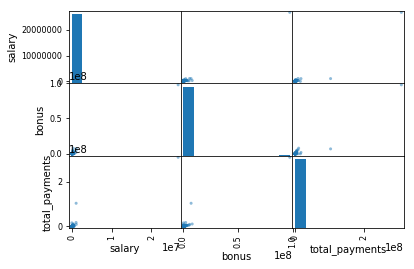

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
scatter_matrix(data[["salary", "bonus", "total_payments"]])

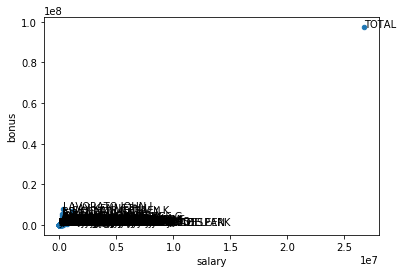

In [169]:
ax = data.plot.scatter(x="salary", y="bonus")
def label_point(data, x, y, ax):
    for i, point in data.iterrows():
        ax.text(point[x], point[y], i)
label_point(data, "salary", "bonus", ax)
plt.draw()

Obviously, there is a "TOTAL" entry in the data set. This is removed since it does not represent a real person.

In [170]:
#features.remove()
TOTAL_IDX = data.index.get_loc("TOTAL")
del features[TOTAL_IDX]
del names[TOTAL_IDX]
del labels[TOTAL_IDX]
data.drop("TOTAL", inplace=True)

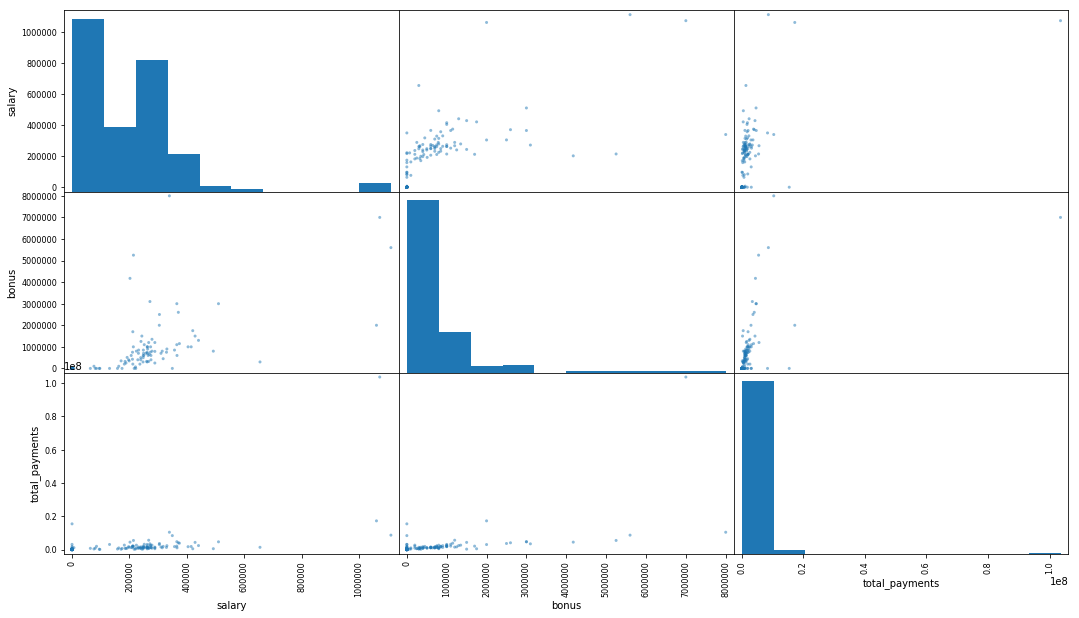

In [171]:
ax = scatter_matrix(data[["salary", "bonus", "total_payments"]], figsize=(18,10))

There is still an outlier in the total payments plot.

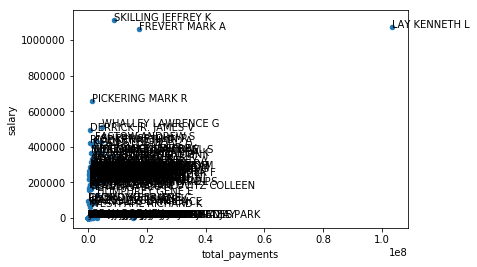

In [172]:
ax = data.plot.scatter(x="total_payments", y="salary")
def label_point(data, x, y, ax):
    for i, point in data.iterrows():
        ax.text(point[x], point[y], i)
label_point(data, "total_payments", "salary", ax)
plt.draw()

Since the outlier is a real person involved in the case I do not remove it.

###  Email features

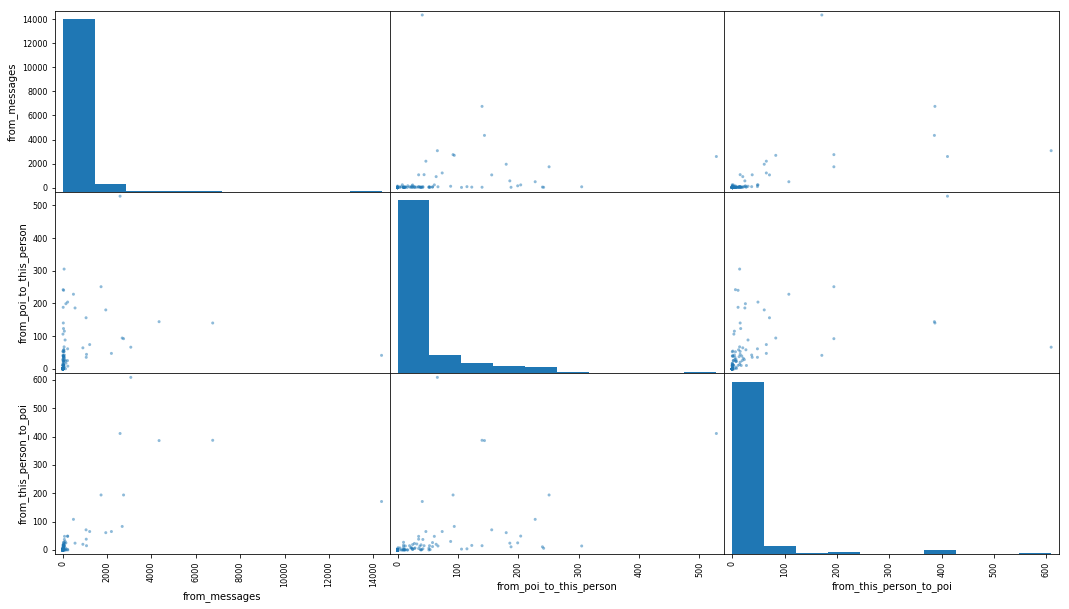

In [173]:
ax = scatter_matrix(data[["from_messages", "from_poi_to_this_person", "from_this_person_to_poi"]], figsize=(18,10))

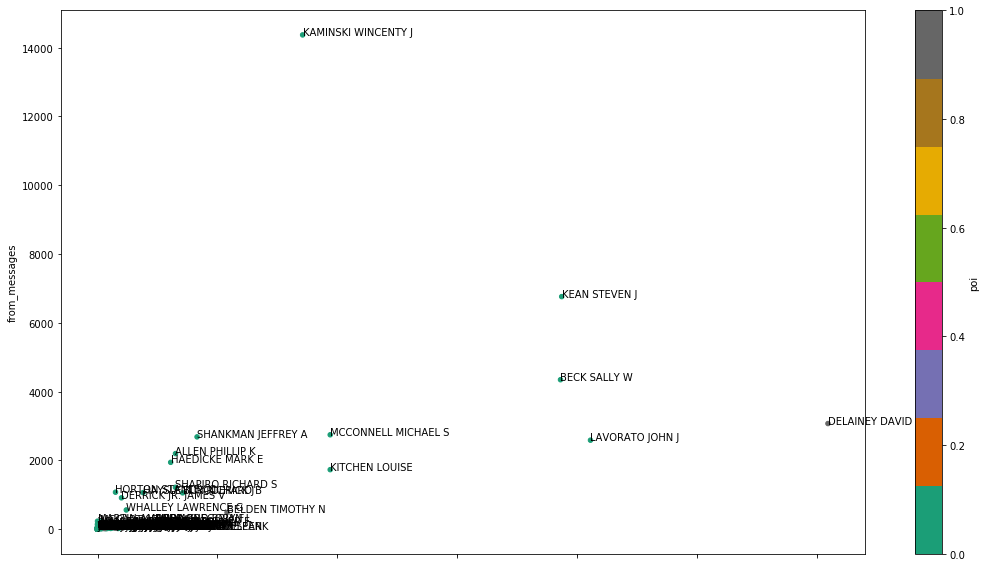

In [181]:
from matplotlib import cm
ax = data.plot.scatter(x="from_this_person_to_poi", y="from_messages", c="poi", figsize=(18, 10), 
                      colormap=cm.Dark2)
label_point(data, "from_this_person_to_poi", "from_messages", ax)


In [104]:
import poi_id
data_dict = poi_id.prepare_data(None, load=True)
labels = []
for key, value in data_dict.items():
    labels.append(value["poi"])

In [105]:
print data_dict[data_dict.keys()[0]].keys()[0:50]

[u'word_keith', u'word_barri', u'word_enjoy', u'word_delainey', u'word_buyer', u'word_obtain', u'word_recogn', u'sub_from_follow up', u'word_adjust', u'word_swap', u'sub_to_out of the office', u'sub_to_please note change midyear 2000 performance review process', u'word_contain', u'sub_to_2000 ena offsite', u'word_chair', u'sub_from_hiring practices for summer interns', u'word_profession', u'sub_from_cgas', u'word_conveni', u'word_chris', u'word_communicationsenron', u'word_infrastructur', u'word_construct', u'word_consult', u'sub_from_congrats', u'word_appli', u'word_vinc', u'sub_from_presentation', u'word_public', u'word_ultim', u'sub_to_enrononline executive summary for december 7 2000', u'sub_from_charts', u'word_act', u'word_encourag', u'sub_from_summer internship', u'word_molli', u'word_repli', u'word_measur', u'word_engin', u'sub_to_netco', u'word_candid', u'sub_from_returned mail user unknown', u'word_ed', u'word_attorney', u'word_texa', u'word_choic', 'exercised_stock_options',

In [110]:
features = []
labels = []
names = []
for key, value in data_dict.items():
    labels.append(value["poi"])
    #value.pop("poi",None)
    features.append(value)
    names.append(key)
    
tsne_viz = TSNE(n_components=2, random_state=42, perplexity=10, early_exaggeration=10).fit_transform(
    Imputer(strategy="median").fit_transform(
        DictVectorizer(sparse=False).fit_transform(features)))

In [111]:
source = ColumnDataSource(data=dict(x=tsne_viz[:,0],
                                    y=tsne_viz[:,1],
                                    names=names,
                                    color=[RdBu3[label*2] for label in labels],
                                   ))
p = figure(plot_width=900, plot_height=500, active_scroll = "wheel_zoom")
p.circle(x="x", y="y", color="color", source=source, size=8)
plot_labels = LabelSet(x="x", y="y", text="names", source=source, level='glyph', render_mode='canvas')
p.add_layout(plot_labels)
show(p)

## Vectorize Email Text

In [3]:
features = []
labels = []
names = []
for key, value in data_dict.items():
    labels.append(value["poi"])
    #value.pop("poi",None)
    features.append(value)
    names.append(key)
            
get_email_text = poi_id.SelectMatchFeatures(feature_match="^word_.*")
email_text = get_email_text.fit_transform(features)

print get_email_text.get_feature_names()[:10]

get_sub = poi_id.SelectMatchFeatures(feature_match="^sub_.*")
subs = get_sub.fit_transform(features)
print get_sub.get_feature_names()[:10]

[u'word_keith', u'word_barri', u'word_enjoy', u'word_delainey', u'word_buyer', u'word_obtain', u'word_recogn', u'word_adjust', u'word_swap', u'word_contain']
[u'sub_from_follow up', u'sub_to_out of the office', u'sub_to_please note change midyear 2000 performance review process', u'sub_to_2000 ena offsite', u'sub_from_hiring practices for summer interns', u'sub_from_cgas', u'sub_from_congrats', u'sub_from_presentation', u'sub_to_enrononline executive summary for december 7 2000', u'sub_from_charts']


In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

import numpy as np
selector = SelectKBest(k=10, score_func=f_classif)
selected_subs_vect = selector.fit_transform(subs, labels)
print sum(selector.get_support())
selected_subs = np.take(get_sub.get_feature_names(),selector.get_support(indices=True))
print selected_subs

10
[u'sub_to_ene friday peer group report'
 u'sub_from_organizational announcement'
 u'sub_to_government affairs organizational changes'
 u'sub_to_policy committee review  analystassociate program prc process'
 u'sub_to_executive committee meeting  monday september 25'
 u'sub_to_executive committee meeting  monday october 16  new sec rules'
 u'sub_to_la times article'
 u'sub_to_rac website  portfolio tracking system'
 u'sub_to_advisory council presentations'
 u'sub_to_enron advisory council presentations']


In [5]:
selected_subs_vect

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.19256373,  0.39366012,  0.2205698 ,
         0.21663419,  0.        ,  0.21608212,  0.41512676,  0.21663419],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.10188219,  0.        ,  0.11669973,
         0.11461747,  0.        ,  0.11432537,  0.        ,  0.11461747],
       [ 0.        ,  0.25617908,  0.0630468 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

In [6]:
poi_id = reload(poi_id)

In [7]:
import pandas as pd
df = pd.DataFrame(selected_subs_vect, index=zip(names, labels), columns=selected_subs)
#type(X.toarray())
df

,sub_to_ene friday peer group report,sub_from_organizational announcement,sub_to_government affairs organizational changes,sub_to_policy committee review analystassociate program prc process,sub_to_executive committee meeting monday september 25,sub_to_executive committee meeting monday october 16 new sec rules,sub_to_la times article,sub_to_rac website portfolio tracking system,sub_to_advisory council presentations,sub_to_enron advisory council presentations
"(METTS MARK, False)",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(CORDES WILLIAM R, False)",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(HANNON KEVIN P, True)",0.00000,1.000000,0.192564,0.393660,0.220570,0.216634,0.000000,0.216082,0.415127,0.216634
"(MEYER ROCKFORD G, False)",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(MCMAHON JEFFREY, False)",0.00000,0.000000,0.101882,0.000000,0.116700,0.114617,0.000000,0.114325,0.000000,0.114617
"(HAEDICKE MARK E, False)",0.00000,0.256179,0.063047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(PIPER GREGORY F, False)",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(HUMPHREY GENE E, False)",0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(BLACHMAN JEREMY M, False)",0.00000,0.000000,0.195373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(SUNDE MARTIN, False)",0.00000,0.000000,0.103340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
df_2 = pd.DataFrame(subs[:,:10], columns=get_sub.get_feature_names()[:10], index=names)
df_2

,sub_from_follow up,sub_to_out of the office,sub_to_please note change midyear 2000 performance review process,sub_to_2000 ena offsite,sub_from_hiring practices for summer interns,sub_from_cgas,sub_from_congrats,sub_from_presentation,sub_to_enrononline executive summary for december 7 2000,sub_from_charts
METTS MARK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CORDES WILLIAM R,0.000000,0.050205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HANNON KEVIN P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MEYER ROCKFORD G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MCMAHON JEFFREY,0.000000,0.038900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.121138,0.000000
HAEDICKE MARK E,0.000000,0.120360,0.070747,0.106397,0.000000,0.000000,0.000000,0.000000,0.074963,0.000000
PIPER GREGORY F,0.955283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HUMPHREY GENE E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BLACHMAN JEREMY M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SUNDE MARTIN,0.000000,0.000000,0.115961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
#selector = SelectKBest(k=10, score_func=f_classif)
selected_word_vect = selector.fit_transform(email_text, labels)
selected_words = np.take(get_email_text.get_feature_names(),selector.get_support(indices=True))
print selected_words

[u'word_ed' u'word_slide' u'word_american' u'word_agenda' u'word_commod'
 u'word_sherri' u'word_applic' u'word_wes' u'word_ann' u'word_calger']


In [10]:
df_words = pd.DataFrame(selected_word_vect, index=names, columns=selected_words)
df_words

,word_ed,word_slide,word_american,word_agenda,word_commod,word_sherri,word_applic,word_wes,word_ann,word_calger
METTS MARK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CORDES WILLIAM R,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HANNON KEVIN P,0.000000,0.000000,0.374456,0.000000,0.000000,0.383079,0.000000,0.000000,0.110487,0.000000
MEYER ROCKFORD G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MCMAHON JEFFREY,0.020712,0.000000,0.000000,0.000000,0.019987,0.000000,0.000000,0.000000,0.000000,0.000000
HAEDICKE MARK E,0.006028,0.014599,0.018496,0.040184,0.084342,0.000000,0.018083,0.010846,0.016372,0.002548
PIPER GREGORY F,0.003510,0.000000,0.000000,0.000000,0.023711,0.004132,0.108813,0.011369,0.010726,0.004451
HUMPHREY GENE E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BLACHMAN JEREMY M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SUNDE MARTIN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
select_fin_feat = poi_id.SelectFeatureList(selected_feature_list=poi_id.FEATURES_FINANCIAL, convert_to_numeric=True)
dict_to_vect = DictVectorizer(sparse=False)
impute = Imputer(strategy="median")
impute.fit_transform(dict_to_vect.fit_transform(select_fin_feat.fit_transform(features)))
select_fin_feat.fit_transform(features)

[{'bonus': 600000.0,
  'deferral_payments': nan,
  'deferred_income': nan,
  'director_fees': nan,
  'exercised_stock_options': nan,
  'expenses': 94299.0,
  'loan_advances': nan,
  'long_term_incentive': nan,
  'other': 1740.0,
  'restricted_stock': 585062.0,
  'restricted_stock_deferred': nan,
  'salary': 365788.0,
  'total_payments': 1061827.0,
  'total_stock_value': 585062.0},
 {'bonus': nan,
  'deferral_payments': nan,
  'deferred_income': nan,
  'director_fees': nan,
  'exercised_stock_options': 651850.0,
  'expenses': nan,
  'loan_advances': nan,
  'long_term_incentive': nan,
  'other': nan,
  'restricted_stock': 386335.0,
  'restricted_stock_deferred': nan,
  'salary': nan,
  'total_payments': nan,
  'total_stock_value': 1038185.0},
 {'bonus': 1500000.0,
  'deferral_payments': nan,
  'deferred_income': -3117011.0,
  'director_fees': nan,
  'exercised_stock_options': 5538001.0,
  'expenses': 34039.0,
  'loan_advances': nan,
  'long_term_incentive': 1617011.0,
  'other': 11350.0,